In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

import functions
from keras.datasets import mnist



from PIL import Image
import os
from scipy.io import loadmat
from glob import glob 

def rgb2gray(rgb):
    coeffs = np.array([0.2125, 0.7154, 0.0721], dtype=rgb.dtype)
    return( rgb @ coeffs )

def load_image_data(data_dir):
    ''' function taken and adapted from https://github.com/rohdelab/PyTransKit'''
    types = ('*.png','*.tiff','*.bmp','*.jpg','*.jpeg','*.mat')
    class_dir = [os.path.join(data_dir,dI) for dI in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,dI))]
    
    x_data, y_data = [], []
    
    for cl in range(len(class_dir)):
        for ext in types:   
            files_read = []
            file_path = os.path.join(class_dir[cl], ext)
            files_read.extend(glob(file_path))
            
            if files_read != []:
                for files in files_read:
                    if ext == '*.mat':
                        x_data.append(loadmat(files)['image'])
                    else:
                        x_data.append((plt.imread(files)))
                    y_data.append(cl)
    if x_data == []:
        print('Wrong file format provided. File types supported: ')
        print(types)
        print('\n In case of mat files, variable name needs to be \'image\'.')
        return (None, None)
    else:   
        #x_data = np.array(x_data)
        y_data = np.array(y_data)
        return (x_data, y_data)
    

def load_data(dataset,label=0):
    '''  Load data for outlier detection. dataset = 'cell_data' , 'liver_nuclei' , 'MNIST' , 'X_ray. 
    The optional label is for the class to be considered inliers. It is not used for 'X_ray' data.  '''
    if dataset == 'MNIST':
        (train_X, train_y), (test_X, test_y) = mnist.load_data() 
        (train_X, train_y) = (train_X[train_y==label],train_y[train_y==label])
        indices = np.arange(len(train_y))
        np.random.shuffle(indices)
        (train_X, train_y) = (train_X[indices], train_y[indices]) 

        n_val = 300
        val_X = train_X[::-1][:n_val] 
        val_y = train_y[::-1][:n_val] 

        n = 500 
        train_X = train_X[:n] 
        train_y = train_y[:n] 
        
        n_test = 501 #nb of images in test data 
        test_X = test_X[:n_test] 
        test_y = test_y[:n_test] 

    elif (dataset == 'X_ray'): 
        # TRAIN DATA:    
        train_dir = './data/'+dataset+'/training/'
        (train_X, train_y) = load_image_data(train_dir)
        for i,bool in enumerate(train_y): 
            if (train_X[i].ndim==3): 
                train_X[i] = np.mean(train_X[i],axis=2)
            train_X[i] = np.array( Image.fromarray(train_X[i]).resize((100,100)) ) 
        train_X = np.array(train_X)
        train_X = (1*(train_X>0)) * train_X 
        #  TEST DATA: 
        test_dir = './data/'+dataset+'/testing/'
        (test_X, test_y) = load_image_data(test_dir)
        # For this data, Testing images have a different shape than Training images, (much more pixels). Thus we resize it thanks to PIL library. 
        n,width, height = train_X.shape
        for i,bool in enumerate(test_y):
            if (test_X[i].ndim==3): 
                test_X[i] = np.mean(test_X[i],axis=2)
            test_X[i] = np.array( Image.fromarray(test_X[i]).resize((width,height)) ) 
        test_X = np.array(test_X)
        test_X = (1*(test_X>0)) * test_X 
        # CALIBRATION DATA:
        n_cal = n - int(n*75/100)
        (val_X,val_y) = (train_X[:n_cal], train_y[:n_cal])
        (train_X,train_y) = (train_X[n_cal:], train_y[n_cal:])
        
    else: # For cell_data and liver_nuclei, not enough observations to consider a calibration dataset 
        train_dir = './data/'+dataset+'/training/'
        (train_X, train_y) = load_image_data(train_dir)
        test_dir = './data/'+dataset+'/testing/'
        (test_X, test_y) = load_image_data(test_dir)
        test_X = np.array(test_X)
        train_X = np.array(train_X)[train_y==label]
        train_y = train_y[train_y==label]
        n = train_X.shape[0]
        (val_X,val_y) = (train_X,train_y) 
    return( (train_X, train_y), (test_X, test_y) , (val_X, val_y)  )


# Load data 

The following cells download image data

In [66]:
dataset = "MNIST"
###### MNIST :  
(train_X, train_y), (test_X, test_y) = mnist.load_data() 
idx = 2    # class considered
(train_X, train_y) = (train_X[train_y==idx],train_y[train_y==idx])
(test_X, test_y) = (test_X[test_y==idx],test_y[test_y==idx])
n = 100 
p = train_X[0].shape[0]
train_X = train_X[:n]
train_y = train_y[:n]

# Descriptive statistics
### Preview data

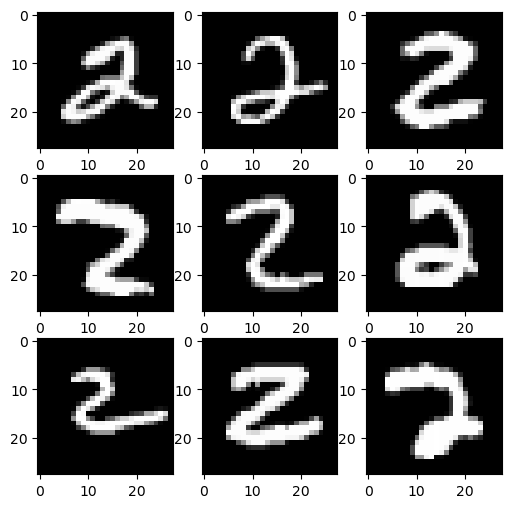

In [67]:
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

# Log-PCA embedding

In [68]:
################################################ 
# Learn Tangent Plan 
################################################ 
V,reference_data = functions.LOT_transform1(train_X,n_sample = 1000)  
# We transform images in point clouds with `n_sample` observations. 
# The bigger n_sample, the more accurate the LOT embedding, but this requires more and more computations. 

Text(0.5, 1.0, 'Data in Log-PCA space ')

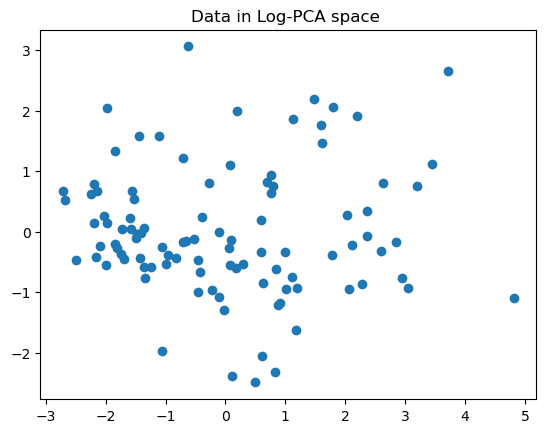

In [69]:
# PCA AND MK QUANTILES IN LOT SPACE, TOWARDS A REDUCED SPACE OF DIMENSION 2 
out,pca,inner_depth,data,outer_depth = functions.PCA_MK_Depth(V,n_components=2) 
plt.scatter(data[:,0],data[:,1])
plt.title("Data in Log-PCA space ")

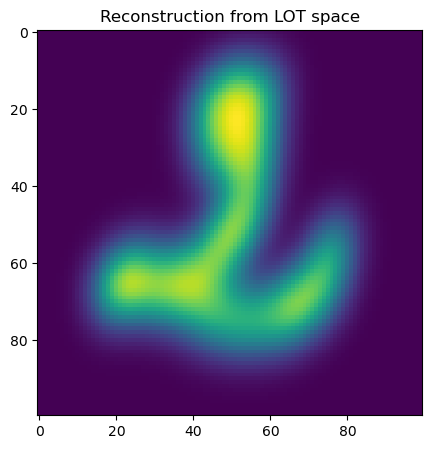

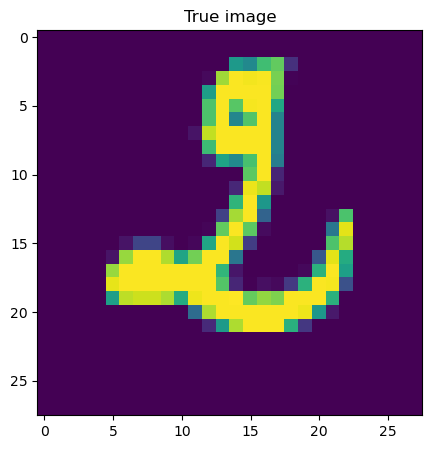

In [70]:
# This cell represents the reconstruction of an image, to be compared with the original image. 
# This highlights the main limitation of the LOT feature space (with the simplex algorithm to solve OT for each embedding). 
nb = 18 
point = functions.LOT_embed_inverse(V[nb],reference_data)
plt.figure(figsize=(5,5))
plt.title("Reconstruction from LOT space")
plt.imshow(functions.pointcloud2image(point) )
plt.figure(figsize=(5,5))
plt.title("True image")
plt.imshow(train_X[nb])

# Learn MK-depth in Log-PCA embedding

In [75]:
################################################ 
# PCA and MK quantiles 
################################################ 
out,pca,inner_depth,data,outer_depth = functions.PCA_MK_Depth(V,n_components=0.7) 

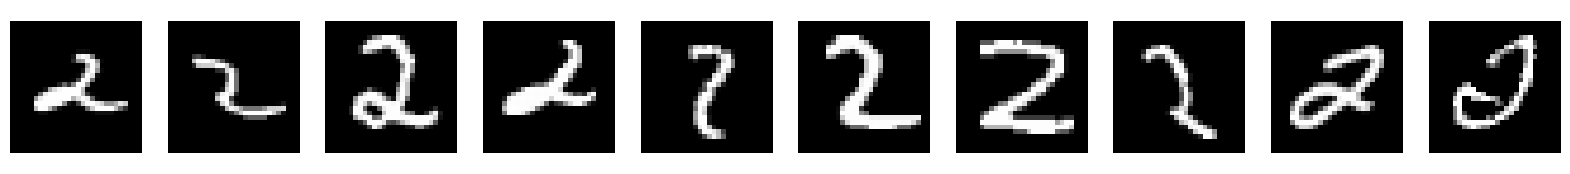

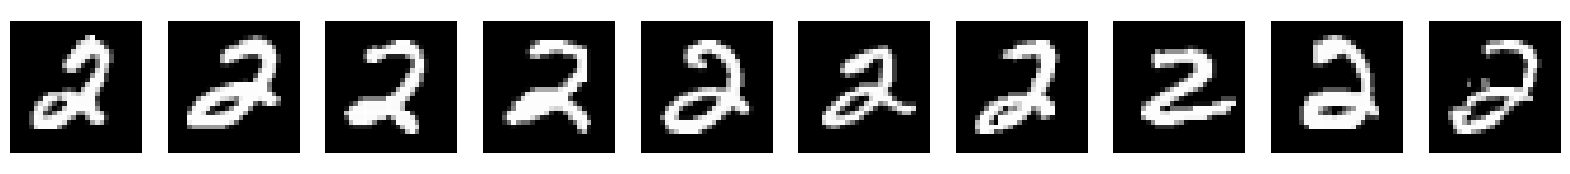

In [76]:
indices_extremes = np.argsort(inner_depth)[:10] #the lowest depth, a.k.a. the most extremes 
indices_centrals = np.argsort(inner_depth)[::-1][0:10] 

plt.figure(figsize=(20,2)) 
plt.axis("off")
#plt.title("Extremes")
for i in range(10):
    plt.subplot(1,10,i+1)
    img = train_X[indices_extremes[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off")

plt.figure(figsize=(20,2))
plt.axis("off")
#plt.title("Centrals")
for i in range(10):
    plt.subplot(1,10,i+1)
    img = train_X[indices_centrals[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off") 

MK deepest point


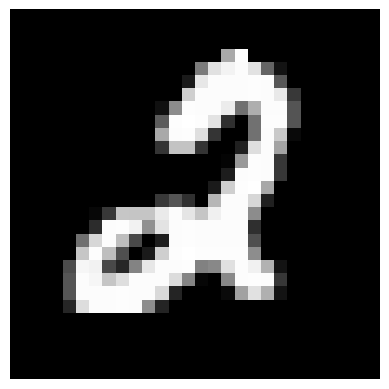

In [77]:
idx = np.argsort(inner_depth)[::-1][0]
img = train_X[idx].reshape(p,p)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis("off")
print("MK deepest point")

# Order statistics and summary() function

Compute min, max and quartiles with respect to the order statistics. 

38
39
48
15


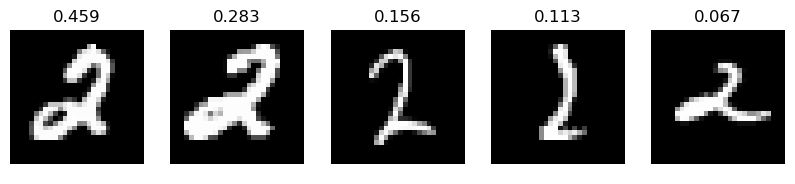

In [78]:
def summary(data,depthMK):
    res = []
    indices = []
    for alpha in [0,0.25,0.5,0.75]:
        print(np.argsort(depthMK)[::-1][int(alpha * len(depthMK))])
        res.append( data[np.argsort(depthMK)[::-1][int(alpha * len(depthMK))] ] )
        indices.append( np.argsort(depthMK)[::-1][int(alpha * len(depthMK))]  )
    # Then the max :
    res.append( data[ np.argsort(depthMK)[0] ] )
    indices.append( np.argsort(depthMK)[0] )
    return(res,indices)

L,indices = summary(train_X,inner_depth) 
plt.figure(figsize=(10,2)) 
plt.axis("off")
for i,img in enumerate(L):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(np.round(inner_depth[indices[i]],3))
    plt.axis("off")
plt.savefig("SummaryDigits2.pdf")

Extremes
Centrals
46
30
98
13


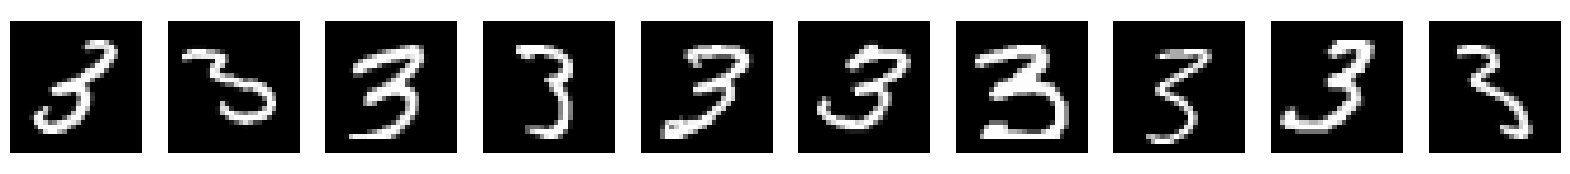

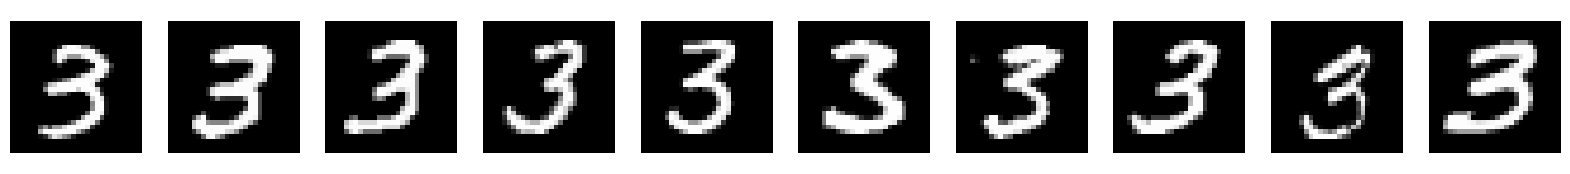

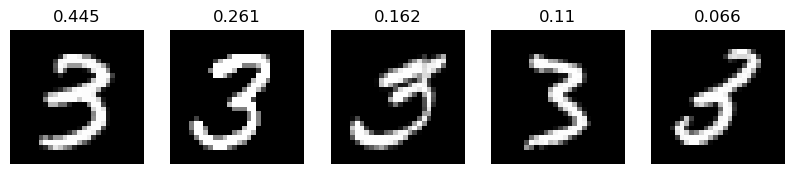

In [ ]:
# Same for another distribution of digits 

(train_X, train_y), (test_X, test_y) = mnist.load_data() 
idx = 3    # class considered
(train_X, train_y) = (train_X[train_y==idx],train_y[train_y==idx])
(test_X, test_y) = (test_X[test_y==idx],test_y[test_y==idx])
n = 100 
p = train_X[0].shape[0]
train_X = train_X[:n]
train_y = train_y[:n]

################################################ 
# Learn Tangent Plan 
################################################ 
V,reference_data = functions.LOT_transform1(train_X,n_sample = 1000) 

################################################ 
# PCA and MK quantiles 
################################################ 
out,pca,inner_depth,data,outer_depth = functions.PCA_MK_Depth(V,n_components=0.7) 


################################################ 
# CENTRAL VERSUS OUTWARD IMAGES     
################################################ 
indices_extremes = np.argsort(inner_depth)[:10] #the lowest depth, a.k.a. the most extremes 
indices_centrals = np.argsort(inner_depth)[::-1][0:10] 

plt.figure(figsize=(20,2)) 
plt.axis("off")
print("Extremes")
for i in range(10):
    plt.subplot(1,10,i+1)
    img = train_X[indices_extremes[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off")
plt.savefig("SummaryDigits3.pdf")


plt.figure(figsize=(20,2))
plt.axis("off")
print("Centrals")
for i in range(10):
    plt.subplot(1,10,i+1)
    img = train_X[indices_centrals[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off") 
plt.savefig("SummaryDigits3.pdf")

################################################ 
# ORDER STATISTICS    
################################################ 

L,indices = summary(train_X,inner_depth) 
plt.figure(figsize=(10,2)) 
plt.axis("off")
for i,img in enumerate(L):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(np.round(inner_depth[indices[i]],3))
    plt.axis("off")
plt.savefig("SummaryDigits3.pdf")



train: (265, 100, 100)
calibration: (75, 100, 100)
test: (49, 100, 100)


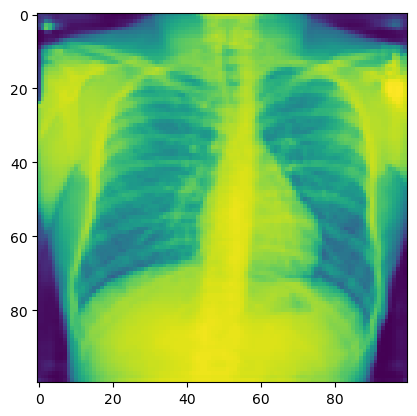

/Users/glthurin/anaconda3/lib/python3.10/site-packages/ot/lp/__init__.py:346: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Extremes
Centrals
151
84
183
81


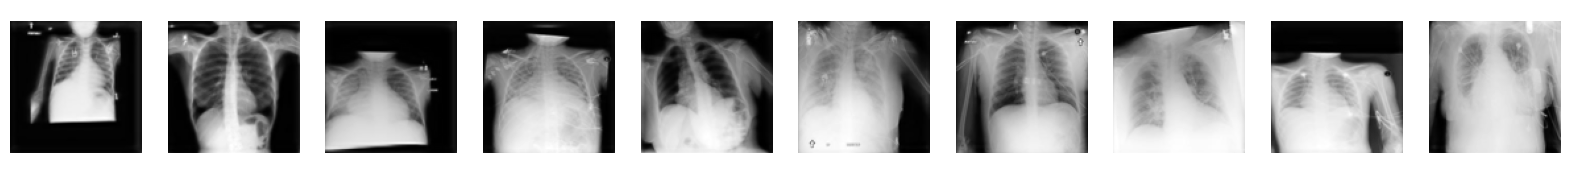

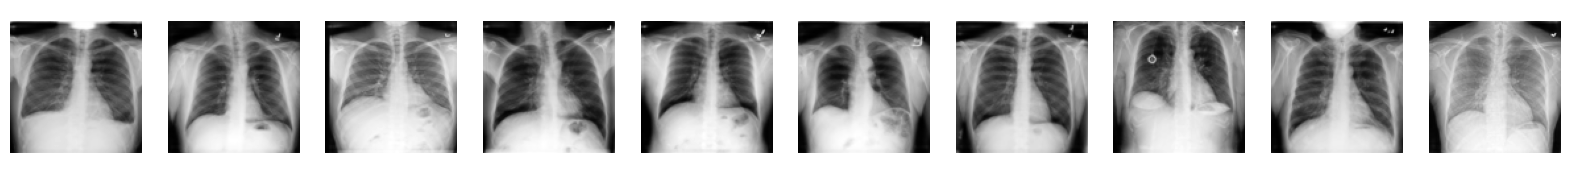

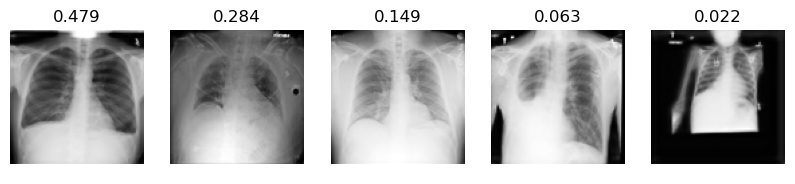

In [56]:

#################################
# LOAD DATA 
#################################
dataset = 'X_ray' #  'cell_data', 'X_ray' , 'liver_nuclei' , 'MNIST' 
label = 0
namedata = dataset+str(label) # To save results according to the data considered 

(train_X, train_y), (test_X, test_y) , (val_X, val_y)  = load_data(dataset,label) 
train_X = np.concatenate([train_X,test_X[test_y==0]])
print("train:",train_X.shape)
print("calibration:",val_X.shape)
print("test:",test_X.shape)
p = train_X.shape[1] 
n = train_X.shape[0] 
plt.imshow(train_X[0]) 
plt.show() 

################################################ 
# Learn Tangent Plan 
################################################ 
V,reference_data = functions.LOT_transform1(train_X,n_sample = 3000) 

################################################ 
# PCA and MK quantiles 
################################################ 
out,pca,inner_depth,data,outer_depth = functions.PCA_MK_Depth(V,n_components=0.7) 

################################################ 
# CENTRAL VERSUS OUTWARD IMAGES     
################################################ 
N = 10
indices_extremes = np.argsort(inner_depth)[:N] #the lowest depth, a.k.a. the most extremes 
indices_centrals = np.argsort(inner_depth)[::-1][0:N] 

plt.figure(figsize=(20,2)) 
plt.axis("off")
print("Extremes")
for i in range(N):
    plt.subplot(1,N,i+1)
    img = train_X[indices_extremes[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off")


plt.figure(figsize=(20,2))
plt.axis("off")
print("Centrals")
for i in range(N):
    plt.subplot(1,N,i+1)
    img = train_X[indices_centrals[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off") 

################################################ 
# ORDER STATISTICS    
################################################ 

L,indices = summary(train_X,inner_depth) 
plt.figure(figsize=(10,2)) 
plt.axis("off")
for i,img in enumerate(L):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(np.round(inner_depth[indices[i]],3))
    plt.axis("off")


Extremes
Centrals
151
84
183
81


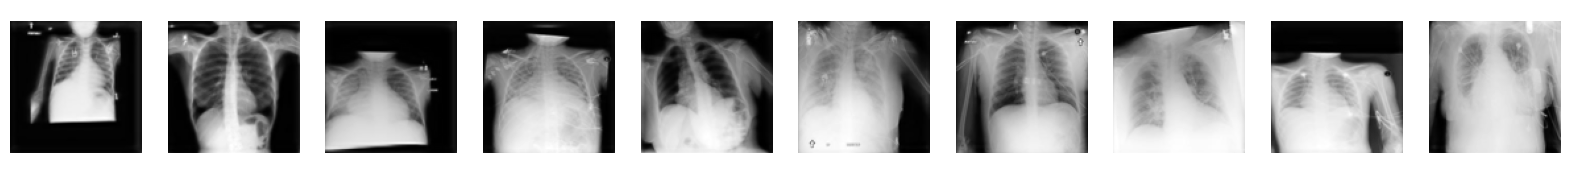

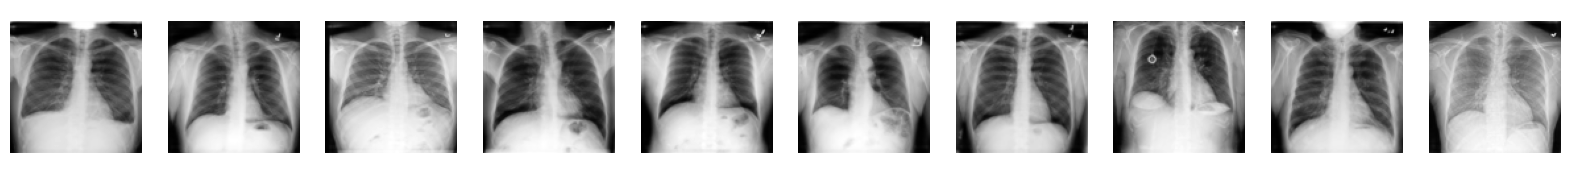

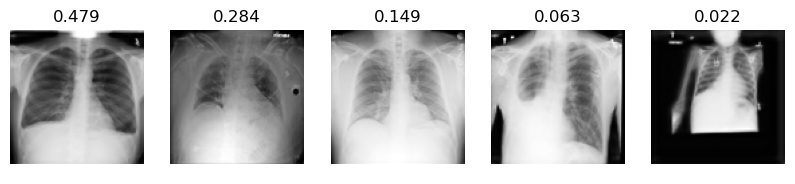

In [58]:

################################################ 
# CENTRAL VERSUS OUTWARD IMAGES     
################################################ 
N = 10
indices_extremes = np.argsort(inner_depth)[:N] #the lowest depth, a.k.a. the most extremes 
indices_centrals = np.argsort(inner_depth)[::-1][0:N] 

plt.figure(figsize=(20,2)) 
plt.axis("off")
print("Extremes")
for i in range(N):
    plt.subplot(1,N,i+1)
    img = train_X[indices_extremes[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off")
plt.savefig("Outward_Xray.jpg")

plt.figure(figsize=(20,2))
plt.axis("off")
print("Centrals")
for i in range(N):
    plt.subplot(1,N,i+1)
    img = train_X[indices_centrals[i]].reshape(p,p)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis("off") 
plt.savefig("Central_Xray.jpg")

################################################ 
# ORDER STATISTICS    
################################################ 

L,indices = summary(train_X,inner_depth) 
plt.figure(figsize=(10,2)) 
plt.axis("off")
for i,img in enumerate(L):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(np.round(inner_depth[indices[i]],3))
    plt.axis("off")


train: (40, 64, 64)
calibration: (40, 64, 64)
test: (50, 64, 64)
37
11
27
23
train: (40, 64, 64)
calibration: (40, 64, 64)
test: (50, 64, 64)
34
36
7
39


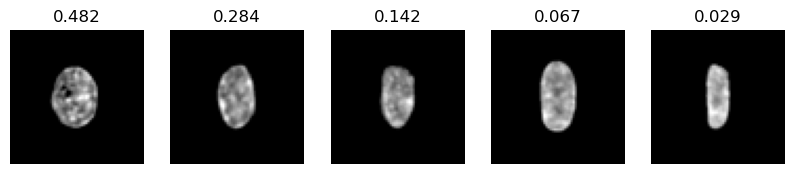

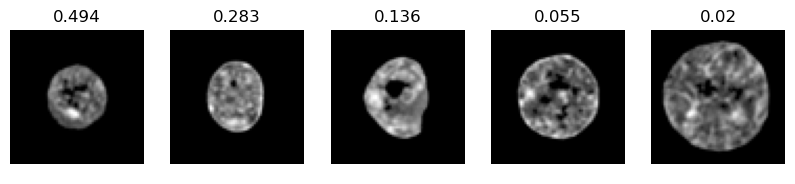

In [ ]:
n_sample = 2000
#################################
# LOAD DATA 
#################################
dataset = 'cell_data' #  'cell_data', 'X_ray' , 'liver_nuclei' , 'MNIST' 
label = 0
namedata = dataset+str(label) # To save results according to the data considered 

(train_X, train_y), (test_X, test_y) , (val_X, val_y)  = load_data(dataset,label) 
print("train:",train_X.shape)
print("calibration:",val_X.shape)
print("test:",test_X.shape)
p = train_X.shape[1] 
n = train_X.shape[0] 

################################################ 
# Learn Tangent Plan 
################################################ 
V,reference_data = functions.LOT_transform1(train_X,n_sample = n_sample) 

################################################ 
# PCA and MK quantiles 
################################################ 
out,pca,inner_depth,data,outer_depth = functions.PCA_MK_Depth(V,n_components=0.7) 

################################################ 
# ORDER STATISTICS    
################################################ 
L,indices = summary(train_X,inner_depth) 
plt.figure(figsize=(10,2)) 
plt.axis("off")
for i,img in enumerate(L):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(np.round(inner_depth[indices[i]],3))
    plt.axis("off")

#################################
# LOAD DATA 
#################################
dataset = 'cell_data' #  'cell_data', 'X_ray' , 'liver_nuclei' , 'MNIST' 
label = 1
namedata = dataset+str(label) # To save results according to the data considered 

(train_X, train_y), (test_X, test_y) , (val_X, val_y)  = load_data(dataset,label) 
print("train:",train_X.shape)
print("calibration:",val_X.shape)
print("test:",test_X.shape)
p = train_X.shape[1] 
n = train_X.shape[0] 

################################################ 
# Learn Tangent Plan 
################################################ 
V,reference_data = functions.LOT_transform1(train_X,n_sample = n_sample) 

################################################ 
# PCA and MK quantiles 
################################################ 
out,pca,inner_depth,data,outer_depth = functions.PCA_MK_Depth(V,n_components=0.7) 

################################################ 
# ORDER STATISTICS    
################################################ 

L,indices = summary(train_X,inner_depth) 
plt.figure(figsize=(10,2)) 
plt.axis("off")
for i,img in enumerate(L):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title(np.round(inner_depth[indices[i]],3))
    plt.axis("off")


# Outlier detection 

train: (225, 100, 100)
calibration: (75, 100, 100)
test: (49, 100, 100)


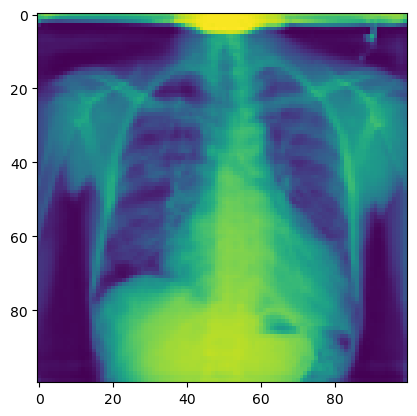

In [ ]:

#################################
# LOAD DATA 
#################################
dataset = 'X_ray' #  'cell_data', 'X_ray' , 'liver_nuclei' , 'MNIST' 
label = 0
namedata = dataset+str(label) # To save results according to the data considered 

(train_X, train_y), (test_X, test_y) , (val_X, val_y)  = load_data(dataset,label) 
print("train:",train_X.shape)
print("calibration:",val_X.shape)
print("test:",test_X.shape)
p = train_X.shape[1] 
n = train_X.shape[0] 
plt.imshow(val_X[0]) 
plt.show() 

In [ ]:
# We transform images in point clouds with `n_sample` observations. For images more complicated than digits, this parameter can be increased. 
if dataset == 'X_ray': 
    n_sample = 10000 
elif dataset == 'MNIST':
    n_sample = 2000
else: 
    n_sample = 5000  

V,reference_data = functions.LOT_transform1(train_X,n_sample=n_sample)
print(V.shape)
df = pd.DataFrame(V)
#df.to_csv("./data/{}/V_train_{}.csv".format(dataset,namedata),index=False)

# Caibration data set:
V_cal = [] 
for X in val_X: 
    Vi = functions.LOT_embed1(X,reference_data) 
    V_cal.append(np.ravel(Vi)) 
V_cal = np.array(V_cal) 
print(V_cal.shape)
df = pd.DataFrame(V_cal)
#df.to_csv("./data/{}/V_cal_{}.csv".format(dataset,namedata),index=False)

# Test data set:
V_test = []
for X in test_X: 
    Vi = functions.LOT_embed1(X,reference_data)
    V_test.append(np.ravel(Vi))
V_test = np.array(V_test)
print(V_test.shape)
df = pd.DataFrame(V_test)
#df.to_csv("./data/{}/V_test_{}.csv".format(dataset,namedata),index=False)


In [21]:
V = np.array( pd.read_csv("./data/{}/V_train_{}.csv".format(dataset,namedata)) )
V_cal = np.array( pd.read_csv("./data/{}/V_cal_{}.csv".format(dataset,namedata)) )
V_test = np.array( pd.read_csv("./data/{}/V_test_{}.csv".format(dataset,namedata)) )

In [ ]:
def inner_outer_depth(Vectors,pca,out):
    # Inner-depth : 
    data = pca.transform(Vectors) 
    xs, ranks_MK = out.transport(data, return_intermediate=False) 
    inner_depth = functions.HalfspaceDepth_pts(ranks_MK)  
    # Outer-depth : 
    Back_projection = pca.inverse_transform(data)
    outer_depth =  1/(1+np.linalg.norm(Vectors - Back_projection,axis=1)) 
    return(inner_depth,outer_depth)

def get_tresholds(alpha, inner_depth, outer_depth):
    inner_orderstats = np.argsort(inner_depth)
    outer_orderstats = np.argsort(outer_depth)
    inner_treshold = inner_depth[ inner_orderstats[int(alpha * len(inner_depth))] ]
    outer_treshold = outer_depth[ outer_orderstats[int(alpha * len(outer_depth))] ]
    return( inner_treshold,outer_treshold )

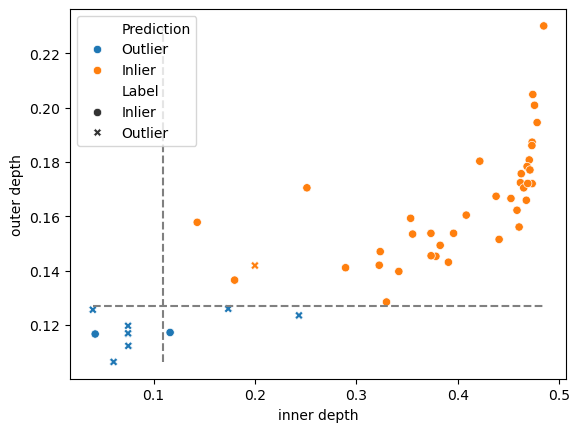

In [28]:

###########################################
# PCA and MK depth on train data
###########################################
out,pca,inner_depth,data,outer_depth = functions.PCA_MK_Depth(V,n_components=0.9)  


###########################################
# Inner and outer depth on calibration data to learn tresholds
###########################################
inner_depth,outer_depth = inner_outer_depth(V_cal,pca,out)
alpha = 0.05
inner_treshold,outer_treshold = get_tresholds(alpha, inner_depth, outer_depth)

###########################################
# Inner and outer depth on test data
###########################################
inner_depth_test,outer_depth_test = inner_outer_depth(V_test,pca,out)

###########################################
# Plot of inner depth versus outer depth
###########################################
idx_inliers = (test_y==label) 
estim_inliers = (inner_depth_test>inner_treshold)&(outer_depth_test>outer_treshold) 

idx__true = [(1*b)*"Inlier"+(1-1*b)*"Outlier" for b in idx_inliers ]
idx__pred = [(1*b)*"Inlier"+(1-1*b)*"Outlier" for b in estim_inliers ]
d = {'inner depth': inner_depth_test, 'outer depth': outer_depth_test, 'Label': idx__true, 'Prediction': idx__pred}
df = pd.DataFrame(data=d) 
sns.scatterplot(data=df, x="inner depth", y="outer depth", style="Label",hue="Prediction",style_order=["Inlier","Outlier"],hue_order=["Outlier","Inlier"])
plt.hlines(outer_treshold,xmin=inner_depth_test.min(),xmax=inner_depth_test.max(),color='gray',linestyle="dashed")
plt.vlines(inner_treshold,ymin=outer_depth_test.min(),ymax=outer_depth_test.max(),color='gray',linestyle="dashed")
plt.legend(loc="upper left")
#plt.savefig("./Figures/OutlierDetection/DDplot{}".format(namedata))

In [29]:
from sklearn.metrics import confusion_matrix,auc

def plot_ROC_curve(tresholds,inner_depth_test,outer_depth_test,idx_inliers):
    toplot = []
    toplot.append([1,1])
    for i,t in enumerate(tresholds):
        inner_treshold = t[0]
        outer_treshold = t[1]  
        estim_inliers = (inner_depth_test>inner_treshold)&(outer_depth_test>outer_treshold)
        tn, fp, fn, tp = confusion_matrix(idx_inliers, estim_inliers).ravel() 
        fpr = fp / (fp + tn)
        tpr = tp / (tp + fn)
        toplot.append( [fpr, tpr] )

    toplot = np.array(toplot)

    plt.figure(figsize=(4,4))
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.plot(toplot[:,0],toplot[:,1],label="Depth-based (AUC = {})".format( np.round(auc(toplot[:,0],toplot[:,1]),2) ),c="darkorange")
    plt.scatter(toplot[:,0],toplot[:,1],s=10,marker="+",c="darkorange")
    plt.plot([0,1],[0,1],c="gray",linestyle="dashed",label="Chance level (AUC = 0.5)")
    plt.legend()


def get_ROC_curve(V_cal,pca,out,V_test,idx_inliers):
    # 1) TRESHOLDS ON CALIBRATION DATA
    inner_depth,outer_depth = inner_outer_depth(V_cal,pca,out)

    # For ROC curve, we consider several levels of tresholds, hence several values for alpha 
    tresholds = []
    for alpha in np.linspace(0,1,101)[1:-1]:
        inner_treshold,outer_treshold = get_tresholds(alpha, inner_depth, outer_depth) 
        tresholds.append([ inner_treshold,outer_treshold ])

    # 2) DECISION ON TEST DATA AND EVALUATION
    inner_depth_test,outer_depth_test = inner_outer_depth(V_test,pca,out)

    plot_ROC_curve(tresholds,inner_depth_test,outer_depth_test,idx_inliers) 


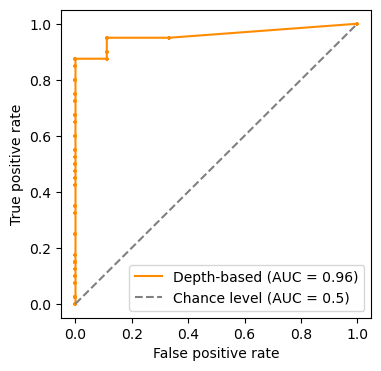

In [31]:
idx_inliers = (test_y==label) 
get_ROC_curve(V_cal,pca,out,V_test,idx_inliers)

# Statistical tests

In [39]:
import sklearn.decomposition as decomposition
# ProgOT 
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.tools import progot
import jax.numpy as jnp
from typing import Any, Optional

def run_progot(
    x: jnp.ndarray, y: jnp.ndarray, cost_fn: costs.TICost, **kwargs: Any
) -> progot.ProgOTOutput:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    estim = progot.ProgOT(**kwargs)
    out = estim(prob)
    return out





In [40]:
def load_shuffle(train_X,train_y, i,j, n_X=200,n_Y=200):
    '''
      - n_X,n_Y give number of images by class. 
      - i,j give the labels to select within train_y.
      - beware that there is at least 'n_X' observations from class i and 'n_Y' observations from class j. 
    '''
    if (i!=j):
      # Distribution mu_X
      df_X = train_X[train_y==i] 
      indices = np.random.choice( df_X.shape[0],n_X , replace=False)
      mu_X = df_X[indices]
      # Distribution mu_Y
      df_Y = train_X[train_y==j]
      indices = np.random.choice( df_Y.shape[0],n_Y , replace=False)
      mu_Y = df_Y[indices]
    else:
       df_ = train_X[train_y==i] 
       indices = np.random.choice( df_.shape[0],n_X+n_Y, replace=False)
       mu_X = df_[indices[:n_X]]
       mu_Y = df_[indices[n_X:]]

    mu_XY = np.concatenate([mu_X,mu_Y])
    class_XY = np.zeros(n_X+n_Y)
    class_XY[n_X:] = 1
    return(mu_XY,class_XY)

from scipy.stats import chi2 

def GoF_test(mu_XY,class_XY,n_sample):
    n_Y = int( class_XY.sum() )
    n_X = int( len(class_XY)-class_XY.sum() )
    p = mu_XY.shape[1]
    # LOT embedding 
    V_XY,reference_img = functions.LOT_transform1(mu_XY,n_sample=n_sample)
    # PCA in 8 dimensions, the dimension determines the treshold of the test statistic 
    pca = decomposition.PCA(n_components=0.95, svd_solver="auto")
    data = pca.fit_transform(V_XY)
    d = pca.n_components_
    # Progressive OT solver in PCA space 
    UnifRanks = np.random.multivariate_normal(np.zeros(d), np.eye(d), data.shape[0])
    epsilons = jnp.array([0.0001]) 
    Ke = len(epsilons)
    alphas = progot.get_alpha_schedule("exp", num_steps=Ke)
    cost_fn = costs.SqEuclidean()
    df_x, df_y = jnp.array(data) ,jnp.array(UnifRanks) 
    out = run_progot(df_x, df_y , cost_fn, alphas=alphas, epsilons=epsilons)
    xs, ranksMK = out.transport(df_x, return_intermediate=False) 

    # Test statistic
    R_X = ranksMK[class_XY==0] 
    R_Y = ranksMK[class_XY==1] 
    #EnergyStat = 2*np.sum(np.sqrt(ot.dist(R_X,R_Y)))/(n_X*n_Y) - np.sum(np.sqrt(ot.dist(R_X,R_X)))/(n_X**2) - np.sum(np.sqrt(ot.dist(R_Y,R_Y)))/(n_Y**2)
    #EnergyStat = EnergyStat * (n_X*n_Y)/(n_X+n_Y) 
    delta = np.mean(R_X,axis=0) - np.mean(R_Y,axis=0) 
    Hotelling = np.dot(delta.T,delta) *(n_X*n_Y)/(n_X+n_Y) 
    treshold = chi2.ppf(0.95, d, loc=0, scale=1) # quantile of order 1 - alpha 
    return(Hotelling,treshold)

### Define distributions to be tested
$$
H_0 : \mu_X = \mu_Y \\
H_1 : \mu_X \ne \mu_Y
$$


In [41]:
def load_data_for_testing(dataset):
    if dataset == "mnist":
        (train_X, train_y), (test_X, test_y) = mnist.load_data() 
        train_X = train_X[:10000]
        train_y = train_y[:10000]
    else:
        train_dir = './data/'+dataset+'/training/'
        (train_X, train_y) = load_image_data(train_dir)
        test_dir = './data/'+dataset+'/testing/'
        (test_X, test_y) = load_image_data(test_dir)
        train_X = np.concatenate([train_X,test_X])
        train_y = np.concatenate([train_y,test_y])
    return(train_X,train_y)

In [42]:
dataset = "mnist"  # 'mnist', 'cell_data', 'liver_nuclei' ,"synthetic_2D" 
train_X,train_y = load_data_for_testing(dataset) 
print(train_X.shape, train_y.shape) 

(10000, 28, 28) (10000,)


In [43]:
i = 5
j = 8
mu_XY,class_XY = load_shuffle(train_X, train_y, i,j, n_X=50,n_Y=50) 

T, treshold = GoF_test(mu_XY,class_XY,n_sample=750)  
T, treshold , 1*(T>treshold)

(97.20466732978821, 73.31149302908324, 1)

# Rejection rates 

In [ ]:
rejection_rates = []
n_X,n_Y = 50,50 # 30 for cell data, 50 for MNIST, 10 for liver-nuclei
n_sample = 750 # 750 for MNIST, 3000 for cell and liver-nuclei
N = 50 # nb of MCMC repetitions
K = len(np.unique(train_y))
rejection_rates = -np.ones((K,K))

for i in range(K):
    for j in range(i,K):
        print("i:",i)
        print("j:",j)
        avgrate = 0  
        for rep in range(N):
            print(rep)
            mu_XY,class_XY = load_shuffle(train_X,train_y, i,j, n_X=n_X,n_Y=n_Y) 
            T, treshold =  GoF_test(mu_XY,class_XY,n_sample=n_sample)
            avgrate = avgrate + 1*(T>treshold)/N   # T>treshold <=> H0 is rejected 
            print(avgrate)
        rejection_rates[i,j] = avgrate 

In [ ]:
df = pd.DataFrame(rejection_rates)
df.to_csv("./Figures/StatTest/rejection_rates_{}.csv".format(dataset),index=False)

In [ ]:
sns.heatmap(rejection_rates,cmap='coolwarm',annot=True)